## 2. Scraping Historical Subreddits for Comments
This notebook 
1. Scraps the comments from the historical daily posts (Daily Discussion Thread) from the wallstreetbets subreddit using two reddit api clients 
2. Calculate sentiment score for each day
3. Compare the sentiment scores with SPY index which serves as overall indicator of US markets
4. Export Data for Time Series Analysis

#### Importing Libraries

In [3]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 300)
import praw #reddit data api
from praw.models import MoreComments # module to get replies to comments
import ffn #for loading financial data
import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer #VADER sentiment model
import requests
import json
import csv
import time
import datetime
import warnings 
warnings.filterwarnings("ignore")
from tqdm import tqdm
import os
from dotenv import load_dotenv

### 1.1 Scraping Comments from 'daily discussion threads' 

#### Collect URLs

In [ ]:
#some variables used in the functions    
sub='wallstreetbets' #Subreddit to scrape
#start and end date of scraping
before = "2021-05-15"
after = "2021-01-01" # starting to scrape in august 2018 when the post first appeared
# define the thread we want to scrape every day
query = "Daily Discussion Thread"
subStats = []
subCount = 0


#function to get reddit post titles and urls with timestamp from pusshift api
def getPushshiftData(query, after, before, sub):
    url = ('https://api.pushshift.io/reddit/search/submission/?title='
           +str(query)+'&size=10000&after='+str(after)+'&before='+str(before)+'&subreddit='+str(sub)) # get Pusshift url
    r = requests.get(url) # get request
    data = json.loads(r.text) # load data into a json file
    return data['data'] # return part of the json file


#get needed data from data scraped above
def collectPosts(post):
    subData = ([post['id'], post['title'], post['url'], 
                datetime.datetime.fromtimestamp(post['created_utc']).date()]) #create list to hold data about posts
    try:
        flair = post['link_flair_text'] # try to get flair of the post
    except KeyError:
        flair = "NaN" # if there is no flai return NaN
    subData.append(flair) # append flair
    subStats.append(subData) # append data 

    
data = getPushshiftData(query, after, before, sub) # get data


# loop will run until all posts have been gathered 
# from the 'after' date up until before date
while len(data) > 0:
    for submission in data:
        collectPosts(submission)
        subCount+=1
    # Calls getPushshiftData() with the created date of the last submission
    after = data[-1]['created_utc']
    data = getPushshiftData(query, after, before, sub)
    

#organize data into dataframe
# create variables
data={} # dictionary in preperation for dataframe
# lists that will contain column values
ids=[]
titles=[]
urls=[]
dates=[]
flairs=[]

# get data into variables
for stat in subStats:
    ids.append(stat[0])
    titles.append(stat[1])
    urls.append(stat[2])
    dates.append(stat[3])
    flairs.append(stat[4])

# append dictionary    
data['id']=ids
data['title']=titles
data['url']=urls
data['date']=dates
data['flair']=flairs

# create dataframe from dictionary

posts=pd.DataFrame(data)
posts=posts[posts['flair']=='Daily Discussion']
posts

#### Scraping URLs of the thread with PRAW and comments

In [5]:
# Setting up Reddit Client for Requests 
load_dotenv() 
client_id = os.environ['CLIENT_ID']
client_secret = os.environ['CLIENT_SECRET']
user_agent = os.environ['USER_AGENT']

reddit = praw.Reddit(client_id=client_id,
                     client_secret=client_secret,
                     user_agent=user_agent)

In [4]:
daily_comments=[] # list that will hold lists of daily comments
for url in tqdm((posts['url'].tolist())): # iterate over urls
    try:
        comments = []
        submission = reddit.submission(url=url) # get comments
        submission.comments.replace_more(limit=0) # this PRAW function allows to access comments and replies 
        for comment in submission.comments: #
            comments.append(comment.body) # append comments and replies to list
        daily_comments.append(comments)
    except:
        comment=None
        comments.append(comment)
        

100%|██████████| 505/505 [23:11<00:00,  2.75s/it]


### 2.2 Apply Vader Sentiment Score to each day
Then sum up sentiment scores for each day 

In [109]:
sia = SentimentIntensityAnalyzer() # import vader sentiment analyzer

scores=[] # list that will hold scores
for comments in tqdm(daily_comments): # iterate over comments by day, a list that holds lists
    sentiment_score=0
    try:
        for comment in comments: # iterate over every comment of every day
            sentiment_score=sentiment_score+sia.polarity_scores(comment)['compound'] # get compund score of comments
        scores.append(sentiment_score) # append to scores list
    except TypeError: #when error occurs
        sentiment_score=0 # set score to zero for the day
        scores.append(sentiment_score) # append score to the scores list
    
posts['sentiment score']=scores

100%|██████████| 505/505 [00:16<00:00, 30.84it/s]


In [110]:
#posts = posts.drop_duplicates(subset = 'date', keep = 'first')
posts['date'] = posts['date'].astype(str)

### 2.3 Merge sentiment data with SPY price
Use SPY, which is the world's largest index fund 

In [111]:
spy=ffn.get('spy', start='2018-01-01') # get spy prices from 01.01.2018
spy['date'] = spy.index.astype(str) # convert date to string 
sent_vals = []

In [112]:
# check if date is in one of the scraped dates, if yes, append to sent_vals
sentiment_df = pd.DataFrame() 
for index, row in posts.iterrows(): # iterate over posts df
    if row[3] in spy['date'].tolist(): # if date is also in spy price table
        temp = spy.loc[spy['date'] == row[3]] # create new table that contains the row of the current iteration
        temp['sent'] = row[5] # update sentiment score for that row
        sentiment_df = sentiment_df.append(temp) # append it to new dataframe   

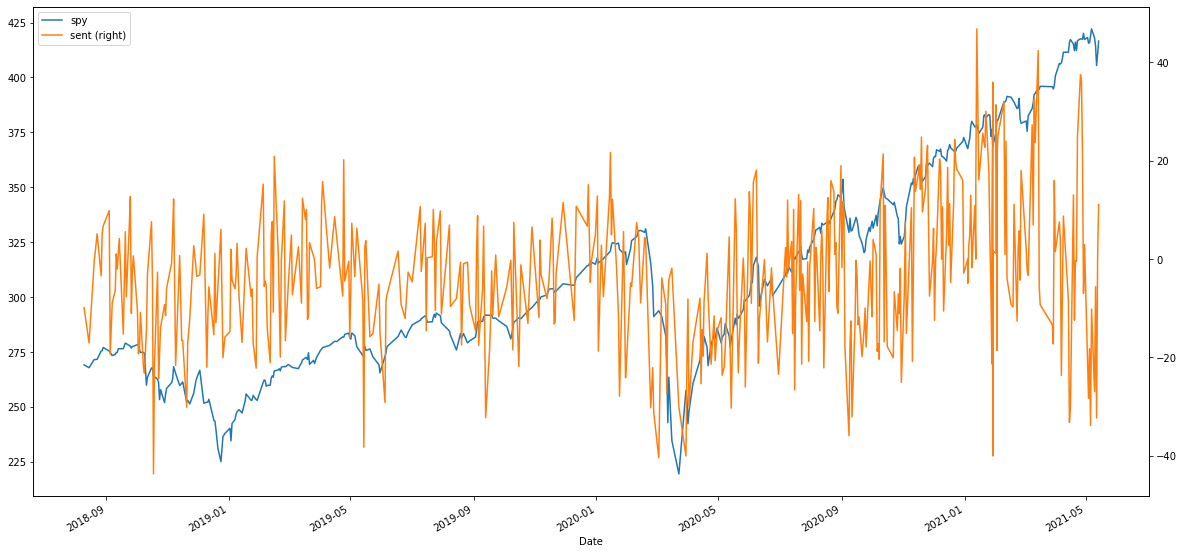

In [113]:
# plot price and sentiment score
# Does not seem to have too much right now
sentiment_df.plot(secondary_y='sent', figsize=(20, 10));

### 2.4 Export Data for Time Series Analysis

In [ ]:
# export dataframe for more detailed analysis
sentiment_df.to_csv("daily_sentiment.csv", index = False)

***